# Imports 

In [30]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import train_test_split, GridSearchCV

In [31]:
# torch specific imports
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

# utils
from torchmetrics import MeanAbsoluteError, R2Score
from torchinfo import summary
from torchvision.io import read_image

In [32]:
# pytorch lightning is more highlevel and allows us to skip boilerplate code
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [33]:
# to make results consistent we seed everything
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Global seed set to 0


In [34]:
# importing datasets
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Resize, Normalize, CenterCrop, ToTensor

# simpledatamodule and simplemodule are simpler versions of objects in pytorch_lightning
# errortracker handles collections of targets and 
#   predictions over each mini-batch in the validation/test stage
from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers

# utils to pull from the IMDb database 
from ISLP.torch.imdb import load_lookup, load_tensor, load_sparse, load_sequential

In [35]:
# glob finds all matching wildcard characters
from glob import glob
import json

# (10.9.1) Single Layer Network on Hitters Data

In [36]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

to_numpy converts pandas df to numpy arrays. We do this because we will use sklearn to fit lasso, and lasso needs this conversion. 

We also use LinearRegression from sklearn to facilitate the comparison

In [37]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()

In [38]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [39]:
# we split into training and test data
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=1/3,random_state=1)

hit_lm = LinearRegression().fit(X_train,Y_train)
Yhat_test = hit_lm.predict(X_test) 
np.abs(Yhat_test - Y_test).mean()

259.71528833146317

We now fit the Lasso using sklearn. We use MAE rather than MSE to fit the model in this case. 

We create a cross-balidation grid and perform the cross-validation directly. 

We encode the pipeline in two steps: 
1) We normalize the features using StandardScaler() transform
2) Fit the lasso without further normalization

In [40]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])

We need to create a grid of values for $\lambda$. We choose a grid of 100 values, uniform on the log scale from lam_max 
down to $0.01\cdot lam_max$. 

Here lam_max is the smallest value of $\lambda$ with an all-zero solution. 
This value equals the largest absolute inner product between any predictor and the (centered) response. 

In [41]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0,np.log(0.01), 100) ) * lam_max}

In [42]:
# now we perform cross validation
cv = KFold(10, shuffle=True, random_state=1)
grid = GridSearchCV(lasso, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)

KeyboardInterrupt: 

In [ ]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

257.23820107995016

We now specify the NN Model. Doing so requires us to specify classes specific to the model we want to fit. 

The way to do it in pytorch is to sub-class a generic representation of a network. 

* nn.Module is ubiquitous in pytorch and represents the mappings in the NN
* flatten and sequential are used in forward to describe the map that this Module implements
* sequential is a composition of 4 maps: 
    1) The input features are mapped to 50 dimensions, introducing in this case 19*50 
     50 parameters for weights and intercepts of the map
    2) This layer is mapped to a ReLU layer 
    3) A 40% dropout layer follows
    4) Linear map down to 1 dimension again with a bias

The total number of trainable parameters is $(19*50+50)+(50+1)=1051$.

The package torchinfo provides a function summary() that summarizes this information. 

In [ ]:
class HittersModel(nn.Module): # nn.Model is ubiquitous in pytorch and represents the mappings in the NN. 
    def __init__(self, input_size) -> None:
        super(HittersModel, self).__init__()
        
        # flatten and sequential are used in forward to describe the map that this module implements
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(nn.Linear(input_size, 50), nn.ReLU(), nn.Dropout(0.4), nn.Linear(50, 1))

    def forward(self, x): 
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [ ]:
hit_model = HittersModel(X.shape[1])

summary(hit_model, input_size=X_train.shape, col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

We now transform the data so that it can be used by torch. The basic datatype in torch is a tensor, which is very similar to an ndarray. torch typically works with 32bit floats, so here's what we will do
1) Convert data to float32
2) Arrange data into a Dataset recognized by torch using TensorDataset()
3) Pass data to a DataLoader() which ultimately passes data to our network.
    * We use the function SimpleDataModule() (from ISLP) to make this task easier for standard usage. The param num_workers indicates how many processes we will use for loading the data.
    * The torch package will inspect the process running and determine the max number of workers. We use the rec_num_workers() in ISLP to compute this

In [ ]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

# same for test data
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

max_num_workers = rec_num_workers()

The general training setup in pytorch_lightning is, for each epoch: 
* Training: learn the model
* Validation: track the error 
* Test: after training

Each is represented by a different data loader.

In this case we only have training and test data so we will use test data as validation (by setting validation=hit_test). The validation argument can also be a float between 0 and 1, in that case is the % of the training data which will be used for validation. It can also be a dataset (in that case that dataset is used for validation)

In [ ]:
hit_dm = SimpleDataModule(hit_train, hit_test, batch_size=32, num_workers=min(4, max_num_workers), validation=hit_test)

Next we must provide a pytorch_lightning module that controls the steps performed in the training process. 

By using SimpleModule.regression() we are specifying we will use squared-error loss. We also indicated that we want to track Mean Absolute Error as mae. 

We log our results via CVSLogger which stores everything in csv file. We do this so that after training we are able to load the results as a dataframe and visualize them.

In [ ]:
hit_module = SimpleModule.regression(hit_model, metrics={'mae': MeanAbsoluteError()})
hit_logger = CSVLogger('logs', name='hitters')

We are now ready to train the model and see the results. We use the Trainer object from pytorch_lightning.
* The argument datamodule=hit_dm specifies how training/validation/test logs are produced
* hit_module specifies the network architecture as well as the training/validation/test steps
* callbacks allows for several tasks to be carried out at various points while training a model. ErrorTracker will allow us to compute the validation error while training and finally the test error

Now we fit the model for 50 epochs. What is happening: 
* At each step of the SGD the algo randomly selects 32 training observations for the computation of the gradient
* An epoch is 5.5 SGD steps

After having fit our model we can evaluate performance on the test set by using .test()

In [ ]:
hit_trainer = Trainer(deterministic=True, 
                      max_epochs=50, 
                      log_every_n_steps=5, 
                      logger=hit_logger, 
                      callbacks=[ErrorTracker()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
hit_trainer.fit(hit_module, datamodule=hit_dm)
print('DONE!')


  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


DONE!


In [ ]:
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              104098.546875
        test_mae            229.50115966796875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 104098.546875, 'test_mae': 229.50115966796875}]

The results have been stored in a csv file, whose filepath is in experiment.metrics_file_path attribute of our logger. 

We now create a plot of MAE vs epochs. 

In [ ]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)
hit_results

,train_mae_step,epoch,step,valid_loss,valid_mae,train_loss,train_mae_epoch,test_loss,test_mae
0,386.986084,0,4,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0,5,145063.593750,237.685242,NaN,NaN,NaN,NaN
2,NaN,0,5,NaN,NaN,715415.250000,561.457336,NaN,NaN
3,273.843872,1,9,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,11,131679.765625,236.432709,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
156,338.384460,49,294,NaN,NaN,NaN,NaN,NaN,NaN
157,198.867279,49,299,NaN,NaN,NaN,NaN,NaN,NaN
158,NaN,49,299,104098.546875,229.501160,NaN,NaN,NaN,NaN
159,NaN,49,299,NaN,NaN,108526.796875,236.133453,NaN,NaN


In [ ]:
def summary_plot(results, 
                 ax,
                 col='loss', 
                 valid_legend='Validation', 
                 training_legend='Training', 
                 ylabel='loss', 
                 fontsize=20):
    for (column, color, label) in zip([f'train_{col}_epoch', f'valid_{col}'], 
                                      ['black', 'red'], 
                                      [training_legend, valid_legend]): 
        results.plot(x='epoch', 
                     y=column, 
                     label=label, 
                     marker='o', 
                     color=color, 
                     ax=ax)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel) 
    return ax

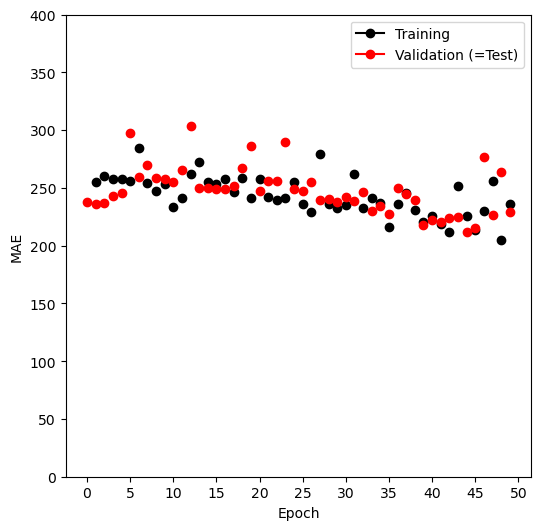

In [ ]:
fig, ax = subplots(1,1,figsize=(6,6))
ax = summary_plot(hit_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')

ax.set_ylim([0,400])
ax.set_xticks(np.linspace(0,50,11).astype(int))

We can predict directly from the final model, and evaluate its performance on the test data.

Before fitting we call the eval() method of hit_model. This tells torch to consider the model to be fitted, so that it can predict on new data. For our model the biggest change is that the dropout layers will be turned off.

In [ ]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

NameError: name 'hit_model' is not defined

In setting up our data module, we had initiated several worker processes
that will remain running. We delete all references to the torch objects to
ensure these processes will be killed

In [ ]:
del(Hitters ,
hit_model , hit_dm ,
hit_logger ,
hit_test , hit_train ,
X, Y,
X_test , X_train ,
Y_test , Y_train ,
X_test_t , Y_test_t ,
hit_trainer , hit_module)

# Multilayer network on the MNIST Digit Data

In [6]:
i = 10
match i: 
    case int(): 
        print('fdasfasfsa')
    case _: 
        print('exception')

print('done')

fdasfasfsa
done


In [10]:
class Test(): 
    def __init__(self) -> None:
        pass

t = Test()
t.__

__main__.Test